In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym

import math, random, time
import matplotlib.pyplot as plt

In [18]:
Tensor = torch.Tensor

env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [16]:
# PARAMS

learning_rate = 0.01
hidden_layer = 64
num_episodes = 500
gamma = 0.85

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

In [5]:
number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    return egreedy_final + (egreedy - egreedy_final) * math.exp(-1 * steps_done / egreedy_decay)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, number_of_outputs)
        self.activation = nn.Tanh()
#         self.activation = nn.ReLU()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        return self.linear2(output1)
        

In [14]:
class QNetAgent(object):
    def __init__(self):
        self.nn = NeuralNetwork() #.to(device)
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
    def select_action(self, state, epsion):
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:
            with torch.no_grad():
                state = Tensor(state) #.to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn, 0)[1]
                action = action.item()
        else:
            action = env.action_space.sample()
            
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        state = Tensor(state) #.to(device)
        new_state = Tensor(new_state) #.to(device)
        reward = Tensor([reward]) #.to(device)
        
        if done:
            target_value = reward
        else:
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
            
        predicted_value = self.nn(state)[action]
        loss = self.loss_func(predicted_value, target_value)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


*** Episode 0 ***                       
Av.reward: [last 10]: 4.40, [last 100]: 0.44, [all]: 44.00                       
epsilon: 0.83, frames_total: 44
Elapsed time:  16:07:1550610456

*** Episode 10 ***                       
Av.reward: [last 10]: 20.80, [last 100]: 2.52, [all]: 22.91                       
epsilon: 0.55, frames_total: 252
Elapsed time:  16:07:1550610456

*** Episode 20 ***                       
Av.reward: [last 10]: 14.10, [last 100]: 3.93, [all]: 18.71                       
epsilon: 0.42, frames_total: 393
Elapsed time:  16:07:1550610456

*** Episode 30 ***                       
Av.reward: [last 10]: 12.30, [last 100]: 5.16, [all]: 16.65                       
epsilon: 0.33, frames_total: 516
Elapsed time:  16:07:1550610456

*** Episode 40 ***                       
Av.reward: [last 10]: 10.90, [last 100]: 6.25, [all]: 15.24                       
epsilon: 0.27, frames_total: 625
Elapsed time:  16:07:1550610456

*** Episode 50 ***                       
Av.re


*** Episode 460 ***                       
Av.reward: [last 10]: 9.80, [last 100]: 9.40, [all]: 10.13                       
epsilon: 0.02, frames_total: 4670
Elapsed time:  16:07:1550610458

*** Episode 470 ***                       
Av.reward: [last 10]: 9.50, [last 100]: 9.49, [all]: 10.12                       
epsilon: 0.02, frames_total: 4765
Elapsed time:  16:07:1550610458

*** Episode 480 ***                       
Av.reward: [last 10]: 9.30, [last 100]: 9.44, [all]: 10.10                       
epsilon: 0.02, frames_total: 4858
Elapsed time:  16:07:1550610458

*** Episode 490 ***                       
Av.reward: [last 10]: 9.30, [last 100]: 9.43, [all]: 10.08                       
epsilon: 0.02, frames_total: 4951
Elapsed time:  16:07:1550610458
Average reward: 10.20
Average number of steps (last 100 episodes): 10.05


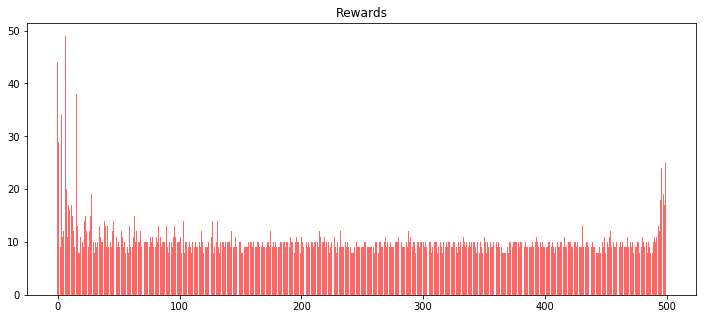

In [22]:
qnet_agent = QNetAgent()

steps_total = []
frames_total = 0
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    state = env.reset()
    step = 0
    while True:
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, total = env.step(action)
        
        qnet_agent.optimize(state, action, new_state, reward, done)
        
        state = new_state
        
        if done:
            steps_total.append(step)
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("Solved after %i episodes", i_episode)
                solved_after = i_episode
                solved = True
            if(i_episode % report_interval == 0):
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )

                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%s"))
            break


print("Average reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average number of steps (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
      print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='red')
plt.show()
      
env.close()
env.env.close()